## Example to load the network, sample 4 levels at random from the latent space and then plot them using matplotlib.


In [146]:
# from google.colab import drive
# drive.mount('/content/drive')

In [147]:
#!cp 'path/to/file' 'path/to/drive'

In [148]:
# import os
# os.chdir("lab6/exercise_DL_pcg")

In [149]:
# !dir

In [150]:
import os
import torch
import matplotlib.pyplot as plt

from vae_mario import VAEMario
from plotting_utilities import plot_decoded_level

In [151]:
# Loading the model
model_name = "mario_vae_zdim_2_overfitted"
z_dim = 2
vae = VAEMario(z_dim=z_dim)
vae.load_state_dict(torch.load(f"./models/{model_name}.pt"))


VAEMario(
  (encoder): Sequential(
    (0): Linear(in_features=2156, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
  )
  (fc_mu): Sequential(
    (0): Linear(in_features=256, out_features=2, bias=True)
  )
  (fc_var): Sequential(
    (0): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=2156, bias=True)
  )
)


<All keys matched successfully>

In [152]:
# Sampling random zs
target_zs = 2.5 * torch.randn((4, z_dim))
levels = vae.decode(target_zs)
level_1 = levels[0]
target = torch.argmax(level_1, dim=0)
target

tensor([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 8, 9, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 8, 9, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 8, 9, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 8, 9, 2, 2, 2],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

I define some functions to improve my z

In [153]:
def find_best_z(target, zs):
    levels = vae.decode(zs)
    best_match = 10000
    z = 0
    for idx, level in enumerate(levels):
        differences = 0
        output = torch.argmax(level, dim=0)
        # Create a matrix of 0 and 1 to show which parts are different
        compare_tensor = (output == target).int()
        _,count = compare_tensor.unique(return_counts=True)
        wrong_tiles = count[0]
        if wrong_tiles < best_match:
            z = zs[idx]
            best_match = wrong_tiles
            print("Found better fitting, new wrong tiles: ", best_match)
    return z, best_match

def improve_z(target, z, noise):
    zs = [z + noise * torch.randn(z_dim) for _ in range(10000)]
    zs = torch.stack(zs)
    return find_best_z(target, zs)

def decimal_range(start, stop, increment):
    while start > stop:
        yield start
        start += increment


Actual search for best fitting

In [154]:
# Create some z in order to find the best fit for the previous target

zs = [z + 0.1 * torch.randn(z_dim) for z in range(100)]
zs = torch.stack(zs)
# First search on large space
z, best = find_best_z(target, zs)
print(best)

# Refine search
new_z = z
# Improve z decreasing noise magnitude while I am approaching solution
for noise in decimal_range(0.5, 0, -0.1):
    print("noise is: ", noise)
    new_z, new_best = improve_z(target, new_z, noise)
    if new_best == 0:
        break
print(new_best)


Found better fitting, new wrong tiles:  tensor(8)
tensor(8)
noise is:  0.5
Found better fitting, new wrong tiles:  tensor(11)
Found better fitting, new wrong tiles:  tensor(8)
Found better fitting, new wrong tiles:  tensor(7)
Found better fitting, new wrong tiles:  tensor(6)
noise is:  0.4
Found better fitting, new wrong tiles:  tensor(6)
Found better fitting, new wrong tiles:  tensor(2)
Found better fitting, new wrong tiles:  tensor(1)
noise is:  0.30000000000000004
Found better fitting, new wrong tiles:  tensor(3)
Found better fitting, new wrong tiles:  tensor(2)
Found better fitting, new wrong tiles:  tensor(1)
noise is:  0.20000000000000004
Found better fitting, new wrong tiles:  tensor(14)
Found better fitting, new wrong tiles:  tensor(4)
Found better fitting, new wrong tiles:  tensor(3)
Found better fitting, new wrong tiles:  tensor(2)
Found better fitting, new wrong tiles:  tensor(1)
noise is:  0.10000000000000003
Found better fitting, new wrong tiles:  tensor(11)
Found better f

In [155]:
# Getting levels from them using the decoder
levels = vae.decode(target_zs)
# print(levels.shape)
level_imgs = [plot_decoded_level(level) for level in levels]

# Creating new images
new_zs = [new_z]*4
new_zs = torch.stack(new_zs)
out_levels = vae.decode(new_zs)
out_level_imgs = [plot_decoded_level(level) for level in out_levels]

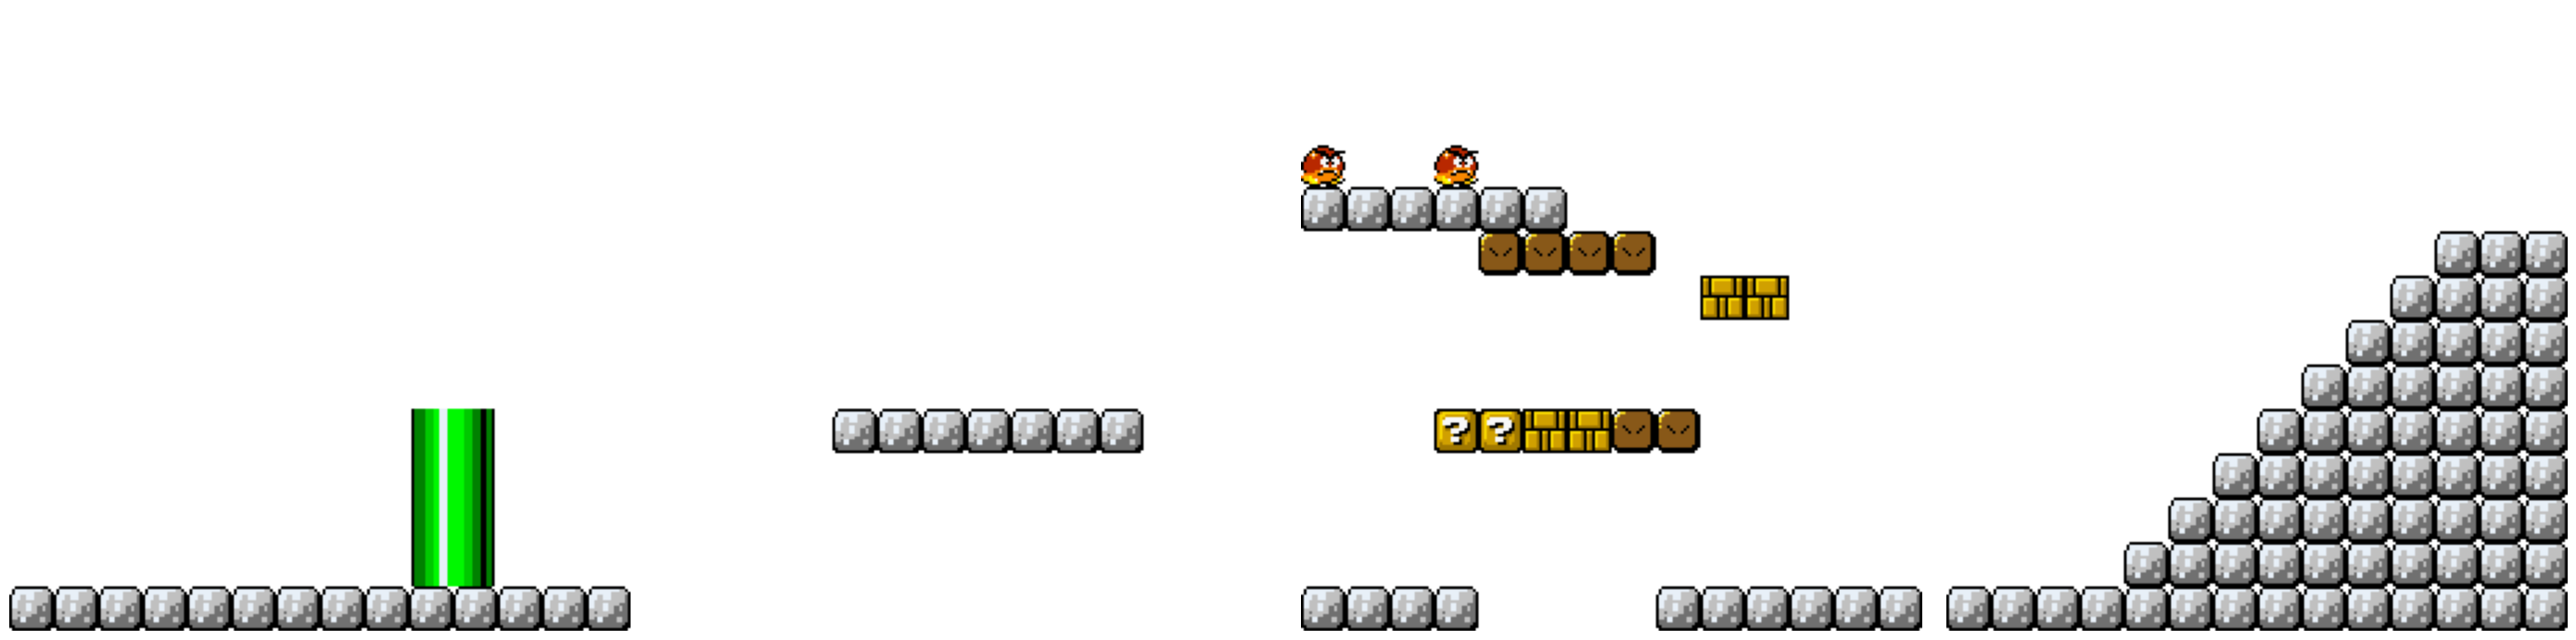

In [156]:
# Plotting
_, axes = plt.subplots(1, 4, figsize=(7 * 4, 7))
for level_img, ax in zip(level_imgs, axes):
    ax.imshow(level_img)
    ax.axis("off")

plt.tight_layout()
plt.show()


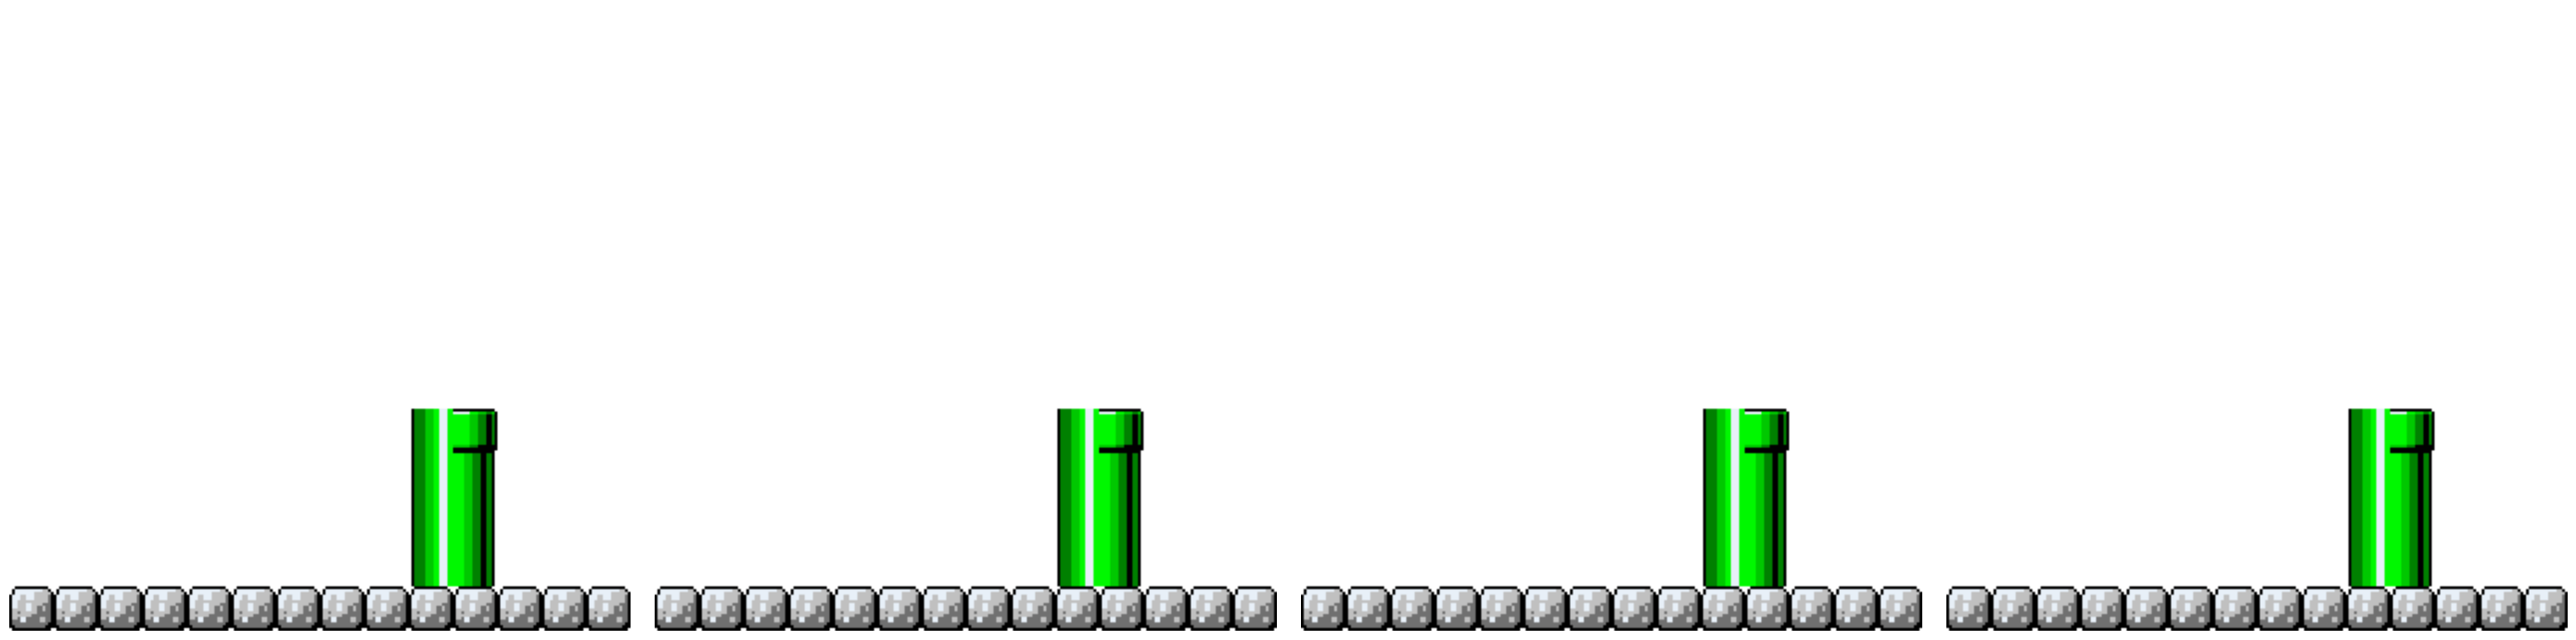

In [157]:
# Plotting reconstructed one
_, axes = plt.subplots(1, 4, figsize=(7 * 4, 7))
for level_img, ax in zip(out_level_imgs, axes):
    ax.imshow(level_img)
    ax.axis("off")

plt.tight_layout()
plt.show()

# Latent Variable Evolution Lab


## Sample from the VAE and then implement some search algorithm of choise to search the latent space for a particular level (e.g. one with many ground tiles)